In [56]:
# MarketScanner



In [57]:
!pip install pandas numpy ccxt yfinance ta backtrader pyyaml



In [58]:
# Cellule 3 — Configuration de la stratégie
config = {
    "assets": {
        "actions": [
            "AAPL","MSFT","AMZN","NVDA","TSLA","META","BRK-B","UNH","V","MA",
            "JNJ","PG","HD","DIS","BAC","XOM","PFE","CSCO","CMCSA","ADBE",
            "NFLX","INTC","PEP","T","KO","ABT","VZ","COST","CRM","WMT",
            "MCD","TMUS","MDT","DHR","LLY","NEE","AMGN","TXN","BMY","UNP",
            "PM","HON","MS","LOW","QCOM","SCHW","C","RTX","GS","LIN"
        ],
        "crypto": ["BTC/USDT", "ETH/USDT"]
    },
    "data": {
        "interval": "1h",
        "start": "2022-01-01",
        "end": None
    },
    "risk": {
        "atr_multiplier": 1.5,
        "risk_per_trade_pct": 1.0
    },
    "backtest": {
        "initial_cash": 100000,
        "commission_pct": 0.1
    }
}


In [59]:
# Cellule 4 — Imports & Data Loader (Code)

from datetime import datetime, timedelta
import pandas as pd
import ccxt, yfinance as yf

def fetch_stock_data(tickers, start, end, interval):
    # Si intraday et start trop ancien, on ajuste à -730j
    if 'h' in interval.lower() and start:
        max_hist = datetime.utcnow() - timedelta(days=730)
        try:
            start_dt = datetime.fromisoformat(start)
        except Exception:
            start_dt = None
        if start_dt and start_dt < max_hist:
            print(f"⚠️ Intraday limité à 730j. Ajustement start : {start_dt.date()} → {max_hist.date()}")
            start = max_hist.strftime('%Y-%m-%d')

    def _download(ivl):
        return yf.download(
            tickers,
            start=start,
            end=end,
            interval=ivl,
            group_by='ticker',
            progress=False
        )

    try:
        raw = _download(interval)
    except Exception as e:
        print(f"⚠️ Erreur Yahoo Finance ({interval}) : {e}")
        raw = None

    # Si pas de data intraday, on retombe sur du daily
    if raw is None or (isinstance(raw, pd.DataFrame) and raw.empty):
        if 'h' in interval.lower():
            print("⚠️ Pas de données intraday disponibles – fallback à intervalle '1d'")
            raw = _download('1d')
        else:
            print("⚠️ Pas de données Yahoo Finance au format attendu")
            return {}

    data = {}
    if isinstance(raw, pd.DataFrame):
        # Multi-index (plusieurs tickers)
        if isinstance(raw.columns, pd.MultiIndex):
            for t in tickers:
                if t in raw.columns.levels[0]:
                    df = raw[t].copy()
                    df.columns = df.columns.str.lower()
                    data[t] = df
                else:
                    print(f"⚠️ Aucune donnée pour {t}")
        else:
            # Un seul ticker
            df = raw.copy()
            df.columns = df.columns.str.lower()
            if len(tickers) == 1:
                data[tickers[0]] = df
            else:
                print("⚠️ Format inattendu de données Yahoo Finance")
    else:
        print("⚠️ Données Yahoo Finance non reconnues")
    return data

def fetch_crypto_data(symbols, since, timeframe):
    exchanges = ['binance', 'kraken', 'coinbasepro']
    all_data = {}
    for sym in symbols:
        df = None
        for ex_name in exchanges:
            try:
                exchange = getattr(ccxt, ex_name)({'enableRateLimit': True})
                ohlcv = exchange.fetch_ohlcv(sym, timeframe=timeframe, since=since)
                df = pd.DataFrame(ohlcv, columns=[
                    'timestamp','open','high','low','close','volume'
                ])
                df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
                df.set_index('datetime', inplace=True)
                df.columns = df.columns.str.lower()
                print(f"✅ {sym} chargé via {ex_name}")
                break
            except Exception as e:
                print(f"⚠️ {ex_name} impossible pour {sym} : {e}")
        if df is not None:
            all_data[sym] = df
        else:
            print(f"❌ Échec pour {sym} sur tous les exchanges")
    return all_data


In [60]:
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator
from ta.volatility import BollingerBands, AverageTrueRange

def add_indicators(df):
    df['rsi'] = RSIIndicator(df['close'], window=14).rsi()
    df['sma50'] = SMAIndicator(df['close'], window=50).sma_indicator()
    df['sma200'] = SMAIndicator(df['close'], window=200).sma_indicator()
    bb = BollingerBands(df['close'], window=20, window_dev=2)
    df['bb_low'] = bb.bollinger_lband()
    df['atr'] = AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
    return df


In [61]:
def generate_signals(df):
    df['signal_tf'] = (
        (df['sma50'] > df['sma200']) &
        (df['close'].shift() < df['sma50'].shift()) &
        (df['close'] > df['sma50'])
    )
    df['signal_mr'] = (
        (df['rsi'] < 30) &
        (df['volume'] > df['volume'].rolling(10).mean() * 1.2)
    )
    df['signal'] = df['signal_tf'] | df['signal_mr']
    df['score'] = df['signal_tf'].astype(int)*0.6 + df['signal_mr'].astype(int)*0.4
    return df[df['score'] >= 0.5]


In [62]:
def compute_position_size(portfolio_value, entry_price, stop_price, risk_pct):
    risk_amount = portfolio_value * (risk_pct/100)
    per_unit_risk = abs(entry_price - stop_price)
    size = risk_amount / per_unit_risk if per_unit_risk > 0 else 0
    return max(int(size), 0)


In [63]:
# 1. Charger les données
stocks = fetch_stock_data(
    config['assets']['actions'],
    config['data']['start'],
    config['data']['end'],
    config['data']['interval']
)
cryptos = fetch_crypto_data(
    config['assets']['crypto'],
    since=None,
    timeframe=config['data']['interval']
)

# 2. Exemple sur AAPL
df = stocks['AAPL'].copy()
df = add_indicators(df)
signals = generate_signals(df)

# 3. Affichage des derniers signaux
print("Signaux pour AAPL :")
print(signals[['close','score']].tail(5))


⚠️ Intraday limité à 730j. Ajustement start : 2022-01-01 → 2023-06-15


ERROR:yfinance:
50 Failed downloads:
ERROR:yfinance:['NEE', 'META', 'KO', 'PM', 'BRK-B', 'QCOM', 'PEP', 'LIN']: YFPricesMissingError('possibly delisted; no price data found  (1h 2023-06-15 -> 2025-06-14 13:39:00-04:00) (Yahoo error = "1h data not available for startTime=1686801600 and endTime=1749922740. The requested range must be within the last 730 days.")')
ERROR:yfinance:['AMGN', 'INTC', 'MDT', 'LLY', 'COST', 'ADBE', 'MS', 'CRM', 'TSLA', 'V', 'HON', 'DHR']: YFPricesMissingError('possibly delisted; no price data found  (1h 2023-06-15 -> 2025-06-14 13:39:01-04:00) (Yahoo error = "1h data not available for startTime=1686801600 and endTime=1749922741. The requested range must be within the last 730 days.")')
ERROR:yfinance:['C', 'NFLX', 'GS', 'TXN', 'DIS', 'AAPL', 'TMUS', 'UNP', 'MSFT', 'SCHW']: YFPricesMissingError('possibly delisted; no price data found  (1h 2023-06-15 -> 2025-06-14 13:39:02-04:00) (Yahoo error = "1h data not available for startTime=1686801600 and endTime=1749922742

⚠️ Pas de données intraday disponibles – fallback à intervalle '1d'
⚠️ binance impossible pour BTC/USDT : binance GET https://api.binance.com/api/v3/exchangeInfo 451  {
  "code": 0,
  "msg": "Service unavailable from a restricted location according to 'b. Eligibility' in https://www.binance.com/en/terms. Please contact customer service if you believe you received this message in error."
}
✅ BTC/USDT chargé via kraken
⚠️ binance impossible pour ETH/USDT : binance GET https://api.binance.com/api/v3/exchangeInfo 451  {
  "code": 0,
  "msg": "Service unavailable from a restricted location according to 'b. Eligibility' in https://www.binance.com/en/terms. Please contact customer service if you believe you received this message in error."
}
✅ ETH/USDT chargé via kraken
Signaux pour AAPL :
Price            close  score
Date                         
2024-11-14  227.670792    0.6
2024-11-18  227.471268    0.6
2025-02-13  241.213684    0.6
2025-02-28  241.523270    0.6
2025-03-07  238.756912    

In [64]:
# Cellule 9 — Scan multi-actions pour opportunités
import pandas as pd

signals_list = []
for ticker, df0 in stocks.items():
    if df0 is None or df0.empty:
        continue

    # 1) Calcul des indicateurs + signaux
    df_ind = add_indicators(df0.copy())
    sig    = generate_signals(df_ind)
    if sig.empty:
        continue

    # 2) Collecte les signaux
    for ts, row in sig.iterrows():
        signals_list.append({
            'ticker': ticker,
            'date'  : ts,
            'close' : row['close'],
            'score' : row['score']
        })

# 3) Construction du DataFrame global
df_signals = pd.DataFrame(signals_list)
df_signals.sort_values(['date','score'], ascending=[False, False], inplace=True)

# 4) Affiche les Top 50
print("Top 50 opportunités :")
display(df_signals.head(50))


Top 50 opportunités :


,ticker,date,close,score
169,KO,2025-06-09,71.263313,0.6
198,VZ,2025-06-06,43.799999,0.6
168,KO,2025-06-04,70.866142,0.6
91,JNJ,2025-05-30,155.210007,0.6
197,VZ,2025-05-30,43.959999,0.6
232,MCD,2025-05-30,312.080017,0.6
196,VZ,2025-05-27,43.500000,0.6
250,MDT,2025-05-16,86.440002,0.6
162,T,2025-05-15,27.330000,0.6
167,KO,2025-05-15,71.104446,0.6


In [65]:
# Cellule 10 — Stop-loss, position sizing & Reward/Risk pour le Top 50 (capital 100 €)

import pandas as pd

# 1) Paramètres
portfolio_value = 100.0                   # capital en euros
atr_mult        = config['risk']['atr_multiplier']
risk_pct        = config['risk']['risk_per_trade_pct']
tp_mult         = 2.0                     # multiple d'ATR pour fixer le take-profit

results = []
for _, sig in df_signals.head(50).iterrows():
    ticker = sig['ticker']
    date   = sig['date']
    entry  = sig['close']

    # 2) Recalcul des indicateurs pour récupérer l'ATR
    df0    = stocks[ticker]
    df_ind = add_indicators(df0.copy())
    atr    = df_ind.loc[date, 'atr']

    # 3) Calcul stop-loss et take-profit
    stop          = entry - atr_mult * atr
    take_profit   = entry + tp_mult * atr

    # 4) Calcul du risque et de la position
    risk_amount      = portfolio_value * (risk_pct/100)           # montant max risqué
    risk_per_unit    = entry - stop                                # perte max par unité
    reward_per_unit  = take_profit - entry                         # gain max par unité
    size             = risk_amount / risk_per_unit if risk_per_unit > 0 else 0
    # si ton broker ne supporte pas les fractions :
    # size = int(size)

    # 5) Ratio Reward/Risk
    rr_ratio = reward_per_unit / risk_per_unit if risk_per_unit > 0 else None

    results.append({
        'ticker':          ticker,
        'date':            date,
        'entry':           round(entry, 2),
        'stop':            round(stop, 2),
        'take_profit':     round(take_profit, 2),
        'size':            round(size, 6),
        'risk_€':          round(risk_amount, 2),
        'risk_per_unit':   round(risk_per_unit, 2),
        'reward_per_unit': round(reward_per_unit, 2),
        'RR_ratio':        round(rr_ratio, 2)
    })

# 6) Construction et affichage du DataFrame final
df_orders = pd.DataFrame(results)
df_orders


,ticker,date,entry,stop,take_profit,size,risk_€,risk_per_unit,reward_per_unit,RR_ratio
0,KO,2025-06-09,71.26,69.71,73.33,0.644580,1.0,1.55,2.07,1.33
1,VZ,2025-06-06,43.80,42.74,45.21,0.946608,1.0,1.06,1.41,1.33
2,KO,2025-06-04,70.87,69.17,73.13,0.589336,1.0,1.70,2.26,1.33
3,JNJ,2025-05-30,155.21,151.24,160.50,0.251902,1.0,3.97,5.29,1.33
4,VZ,2025-05-30,43.96,42.82,45.48,0.879381,1.0,1.14,1.52,1.33
5,MCD,2025-05-30,312.08,304.71,321.90,0.135713,1.0,7.37,9.82,1.33
6,VZ,2025-05-27,43.50,42.29,45.12,0.825034,1.0,1.21,1.62,1.33
7,MDT,2025-05-16,86.44,83.91,89.81,0.395374,1.0,2.53,3.37,1.33
8,T,2025-05-15,27.33,26.24,28.79,0.915422,1.0,1.09,1.46,1.33
9,KO,2025-05-15,71.10,69.00,73.90,0.476275,1.0,2.10,2.80,1.33


In [66]:
# Cellule 11 — Export CSV des ordres
csv_path = 'orders_top50.csv'
df_orders.to_csv(csv_path, index=False)
print(f"✅ Ordres exportés dans : {csv_path}")


✅ Ordres exportés dans : orders_top50.csv


In [67]:
# Cellule 12 — Simulation d'envoi (dry-run)
for _, order in df_orders.iterrows():
    print(f"[DRY-RUN] BUY {order['size']} of {order['ticker']} @ {order['entry']} €  "
          f"stop={order['stop']} tp={order['take_profit']}  RR={order['RR_ratio']}")


[DRY-RUN] BUY 0.64458 of KO @ 71.26 €  stop=69.71 tp=73.33  RR=1.33
[DRY-RUN] BUY 0.946608 of VZ @ 43.8 €  stop=42.74 tp=45.21  RR=1.33
[DRY-RUN] BUY 0.589336 of KO @ 70.87 €  stop=69.17 tp=73.13  RR=1.33
[DRY-RUN] BUY 0.251902 of JNJ @ 155.21 €  stop=151.24 tp=160.5  RR=1.33
[DRY-RUN] BUY 0.879381 of VZ @ 43.96 €  stop=42.82 tp=45.48  RR=1.33
[DRY-RUN] BUY 0.135713 of MCD @ 312.08 €  stop=304.71 tp=321.9  RR=1.33
[DRY-RUN] BUY 0.825034 of VZ @ 43.5 €  stop=42.29 tp=45.12  RR=1.33
[DRY-RUN] BUY 0.395374 of MDT @ 86.44 €  stop=83.91 tp=89.81  RR=1.33
[DRY-RUN] BUY 0.915422 of T @ 27.33 €  stop=26.24 tp=28.79  RR=1.33
[DRY-RUN] BUY 0.476275 of KO @ 71.1 €  stop=69.0 tp=73.9  RR=1.33
[DRY-RUN] BUY 0.209642 of ABT @ 133.35 €  stop=128.58 tp=139.71  RR=1.33
[DRY-RUN] BUY 0.687992 of VZ @ 43.48 €  stop=42.03 tp=45.42  RR=1.33
[DRY-RUN] BUY 0.10802 of MCD @ 312.71 €  stop=303.45 tp=325.05  RR=1.33
[DRY-RUN] BUY 0.069301 of LIN @ 452.98 €  stop=438.55 tp=472.21  RR=1.33
[DRY-RUN] BUY 0.191471 

In [68]:
print("Tickers chargés :", list(stocks.keys()))


Tickers chargés : ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'TSLA', 'META', 'BRK-B', 'UNH', 'V', 'MA', 'JNJ', 'PG', 'HD', 'DIS', 'BAC', 'XOM', 'PFE', 'CSCO', 'CMCSA', 'ADBE', 'NFLX', 'INTC', 'PEP', 'T', 'KO', 'ABT', 'VZ', 'COST', 'CRM', 'WMT', 'MCD', 'TMUS', 'MDT', 'DHR', 'LLY', 'NEE', 'AMGN', 'TXN', 'BMY', 'UNP', 'PM', 'HON', 'MS', 'LOW', 'QCOM', 'SCHW', 'C', 'RTX', 'GS', 'LIN']


In [69]:
# Cellule 9 — Stop-loss & Position sizing pour AAPL
for ts, row in signals.iterrows():
    entry = row['close']
    # on récupère l'ATR calculé plus tôt dans df
    atr   = df.loc[ts, 'atr']
    stop  = entry - config['risk']['atr_multiplier'] * atr
    size  = compute_position_size(
        portfolio_value = config['backtest']['initial_cash'],
        entry_price     = entry,
        stop_price      = stop,
        risk_pct        = config['risk']['risk_per_trade_pct']
    )
    print(f"{ts.date()} → Buy @ {entry:.2f}, Stop @ {stop:.2f}, Taille = {size} actions")


2024-08-09 → Buy @ 215.23, Stop @ 205.28, Taille = 100 actions
2024-09-05 → Buy @ 221.60, Stop @ 214.20, Taille = 135 actions
2024-09-19 → Buy @ 228.07, Stop @ 220.36, Taille = 129 actions
2024-10-08 → Buy @ 224.98, Stop @ 217.89, Taille = 141 actions
2024-11-07 → Buy @ 226.68, Stop @ 220.43, Taille = 159 actions
2024-11-14 → Buy @ 227.67, Stop @ 221.70, Taille = 167 actions
2024-11-18 → Buy @ 227.47, Stop @ 221.42, Taille = 165 actions
2025-02-13 → Buy @ 241.21, Stop @ 231.92, Taille = 107 actions
2025-02-28 → Buy @ 241.52, Stop @ 232.71, Taille = 113 actions
2025-03-07 → Buy @ 238.76, Stop @ 229.73, Taille = 110 actions


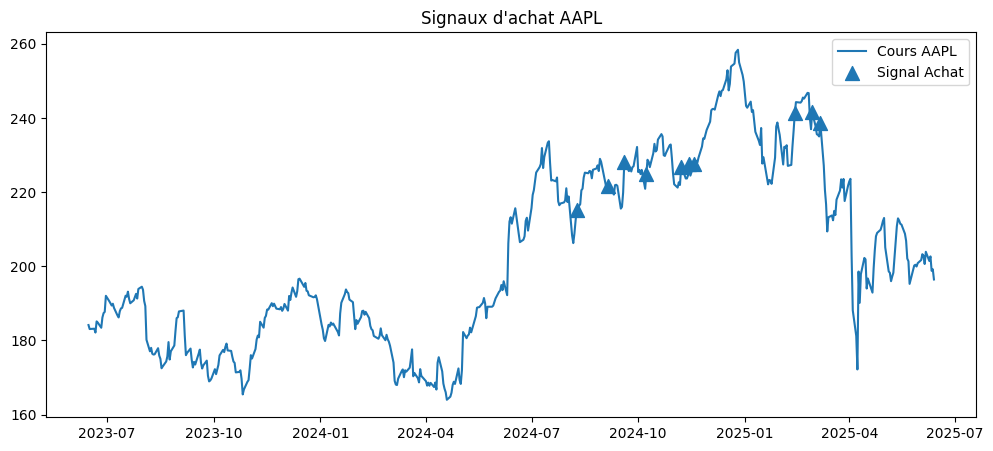

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df.index, df['close'], label='Cours AAPL')
plt.scatter(signals.index, signals['close'], marker='^', s=100,
            label='Signal Achat', zorder=5)
plt.title("Signaux d'achat AAPL")
plt.legend()
plt.show()
